In [1]:
import os
import sys
import nltk
import argparse
import logging
import datetime
import json
import time
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from textwrap import wrap

from transformers import AutoTokenizer
from transformers import AutoProcessor
from transformers import CLIPVisionConfig, CLIPVisionModel, CLIPVisionModelWithProjection
from transformers import TrainingArguments, Trainer

import torch
from torch.utils.data import DataLoader
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torchvision.transforms import Lambda
from torch.utils.tensorboard import SummaryWriter

from dataset_config import COCO_dataset_config
from train_configuration import DatasetType, TrainConfiguration
from custom_datasets.coco_dataset import COCOTrainDataset, COCOEvalDataset
from utils import show_image_caption

%matplotlib inline

/home/kjh/anaconda3/envs/my_env_NICE/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda'
print('Use ', torch.cuda.get_device_name(device))

Use  NVIDIA GeForce RTX 2080 Ti


### Configuration

In [3]:
from transformers import Blip2Config, Blip2VisionConfig, Blip2QFormerConfig, OPTConfig

# configuration = Blip2Config()
# vision_config = Blip2VisionConfig()
# qformer_config = Blip2QFormerConfig()
# text_config = OPTConfig()

# config = Blip2Config.from_text_vision_config(vision_config, qformer_config, text_config)

In [4]:
# blip2 설정 참고하기
# https://github.com/salesforce/LAVIS/blob/main/lavis/projects/blip2/train/caption_coco_ft.yaml

checkpoint = "Salesforce/blip2-opt-2.7b"
dtype = torch.float16

model_name = checkpoint.split("/")[1]

training_args = TrainingArguments(
    output_dir=f"../training_outputs/{model_name}",
    learning_rate=1e-5,
    num_train_epochs=50,
    fp16=True,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=2,
    save_total_limit=3,
    evaluation_strategy="epoch",
    eval_steps=50,
    save_strategy="epoch",
    save_steps=50,
    logging_steps=50,
    remove_unused_columns=False,
    push_to_hub=False,
    label_names=["texts"],
    load_best_model_at_end=True,
    optim='adamw_hf',
    lr_scheduler_type='linear', # github에서는 linear_warmup_cosine_lr <- 구현해놓은건지 확인 필요
)

In [5]:
# dataset_type = DatasetType.COCO
# epochs = 100
# batch_size = 1
# lr = 1e-4
# embed_size = 256


# train_configuration = TrainConfiguration(
#     dataset_type=dataset_type,
#     epochs=epochs,
#     batch_size=batch_size,
#     lr=lr,
#     embed_size=embed_size,
#     dtype=dtype,
# )

### Processor
##### image-processor + tokenizer

In [6]:
from transformers import Blip2Processor

processor = Blip2Processor.from_pretrained(
    checkpoint,
    cache_dir='../pretrained_files',
)


### Dataset

In [7]:
train_ds = COCOTrainDataset(
    img_dir="../datasets/COCO/images/train2017",
    ann_file="../datasets/COCO/annotations/captions_train2017.json",
    vis_processor=processor.image_processor,
    text_processor=processor.tokenizer,
)

test_ds = COCOEvalDataset(
    img_dir="../datasets/COCO/images/val2017",
    ann_file="../datasets/COCO/annotations/captions_val2017.json",
    vis_processor=processor.image_processor,
    text_processor=processor.tokenizer,
)

loading annotations into memory...
Done (t=0.93s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


### Plot Images

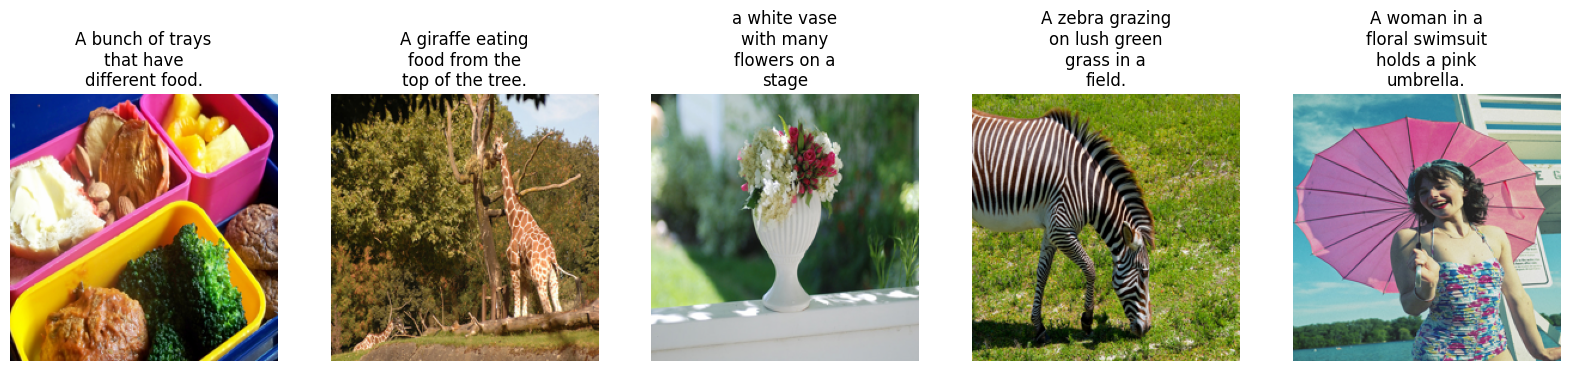

In [8]:
def denormalize_image(normalized_image, mean, std):
    image = normalized_image.transpose(1, 2, 0)
    image = std * image + mean
    image = np.clip(image, 0, 1)
    
    return image

def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 16))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")

num_samples = 5
samples = [train_ds[i] for i in range(num_samples)]

sample_images = []
sample_captions = []
for i in range(num_samples):
    sample_image = np.array(samples[i]['image']['pixel_values'][0])
    sample_image = denormalize_image(sample_image, processor.image_processor.image_mean, processor.image_processor.image_std)
    sample_images.append(sample_image)
    
    sample_caption = ''.join(processor.batch_decode(samples[i]['text_input']['input_ids'], skip_special_tokens=True))
    sample_captions.append(sample_caption)

plot_images(sample_images, sample_captions)

### Model

In [9]:
device_map = {
    "query_tokens": 0,
    "vision_model.embeddings": 0,
    "vision_model.encoder.layers.0": 0,
    "vision_model.encoder.layers.1": 0,
    "vision_model.encoder.layers.2": 0,
    "vision_model.encoder.layers.3": 0,
    "vision_model.encoder.layers.4": 0,
    "vision_model.encoder.layers.5": 0,
    "vision_model.encoder.layers.6": 0,
    "vision_model.encoder.layers.7": 0,
    "vision_model.encoder.layers.8": 0,
    "vision_model.encoder.layers.9": 0,
    "vision_model.encoder.layers.10": 1,
    "vision_model.encoder.layers.11": 1,
    "vision_model.encoder.layers.12": 1,
    "vision_model.encoder.layers.13": 1,
    "vision_model.encoder.layers.14": 1,
    "vision_model.encoder.layers.15": 1,
    "vision_model.encoder.layers.16": 1,
    "vision_model.encoder.layers.17": 1,
    "vision_model.encoder.layers.18": 1,
    "vision_model.encoder.layers.19": 1,
    "vision_model.encoder.layers.20": 1,
    "vision_model.encoder.layers.21": 1,
    "vision_model.encoder.layers.22": 1,
    "vision_model.encoder.layers.23": 1,
    "vision_model.encoder.layers.24": 1,
    "vision_model.encoder.layers.25": 1,
    "vision_model.encoder.layers.26": 1,
    "vision_model.encoder.layers.27": 1,
    "vision_model.encoder.layers.28": 1,
    "vision_model.encoder.layers.29": 1,
    "vision_model.encoder.layers.30": 1,
    "vision_model.encoder.layers.31": 1,
    "vision_model.encoder.layers.32": 1,
    "vision_model.encoder.layers.33": 1,
    "vision_model.encoder.layers.34": 1,
    "vision_model.encoder.layers.35": 1,
    "vision_model.encoder.layers.36": 1,
    "vision_model.encoder.layers.38": 1,
    "vision_model.post_layernorm": 1,
    "qformer": 1,
    "language_projection": 1,
    "language_model.model.decoder.embed_tokens": 1,
    "language_model.lm_head": 2,
    "language_model.model.decoder.embed_positions": 2,
    "language_model.model.decoder.final_layer_norm": 2,
    "language_model.model.decoder.layers.0": 2,
    "language_model.model.decoder.layers.1": 2,
    "language_model.model.decoder.layers.2": 2,
    "language_model.model.decoder.layers.3": 2,
    "language_model.model.decoder.layers.4": 2,
    "language_model.model.decoder.layers.5": 2,
    "language_model.model.decoder.layers.6": 2,
    "language_model.model.decoder.layers.7": 2,
    "language_model.model.decoder.layers.8": 2,
    "language_model.model.decoder.layers.9": 2,
    "language_model.model.decoder.layers.10": 2,
    "language_model.model.decoder.layers.11": 2,
    "language_model.model.decoder.layers.12": 2,
    "language_model.model.decoder.layers.13": 2,
    "language_model.model.decoder.layers.14": 3,
    "language_model.model.decoder.layers.15": 3,
    "language_model.model.decoder.layers.16": 3,
    "language_model.model.decoder.layers.17": 3,
    "language_model.model.decoder.layers.18": 3,
    "language_model.model.decoder.layers.19": 3,
    "language_model.model.decoder.layers.20": 3,
    "language_model.model.decoder.layers.21": 3,
    "language_model.model.decoder.layers.22": 3,
    "language_model.model.decoder.layers.23": 3,
    "language_model.model.decoder.layers.24": 3,
    "language_model.model.decoder.layers.25": 3,
    "language_model.model.decoder.layers.26": 3,
    "language_model.model.decoder.layers.27": 3,
    "language_model.model.decoder.layers.28": 3,
    "language_model.model.decoder.layers.29": 3,
    "language_model.model.decoder.layers.30": 3,
    "language_model.model.decoder.layers.31": 3,
    "vision_model.encoder.layers.37": 1
}

In [10]:
from transformers import Blip2ForConditionalGeneration

model = Blip2ForConditionalGeneration.from_pretrained(
    checkpoint,
    cache_dir='../pretrained_files',
    torch_dtype=dtype,
    device_map=device_map
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:11<00:00,  5.58s/it]


### Training

In [11]:
def compute_metrics(pred):
    # loss = pred["loss"]
    return pred

In [12]:
# https://github.com/salesforce/LAVIS/blob/5ee63d688ba4cebff63acee04adaef2dee9af207/lavis/models/blip2_models/blip2_opt.py
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

In [ ]:
# def train(model, dataloader):
#     logging.info("Start Training...")
#     for image, caption in tqdm(dataloader):
#         print(caption)
#         # plt.imshow(image[0])
#         # print(caption[0])
        
        
#         loss = model.opt_model()
#         # loss = model._modules['vision_model']
#         show_image_caption(image, caption, save_path='./sample.png')
#         break